In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from skimage import io
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev
import pipeline as pipe
import time
import superpixels as sp

In [3]:
ground_path = 'BSDS500/data/groundTruth/val/'
train_path = 'BSDS500/data/images/val/'
save_path = 'save/'
bound_prefix = save_path + 'bound_'
eval_prefix = save_path + 'precision_'
extension = '.npz'

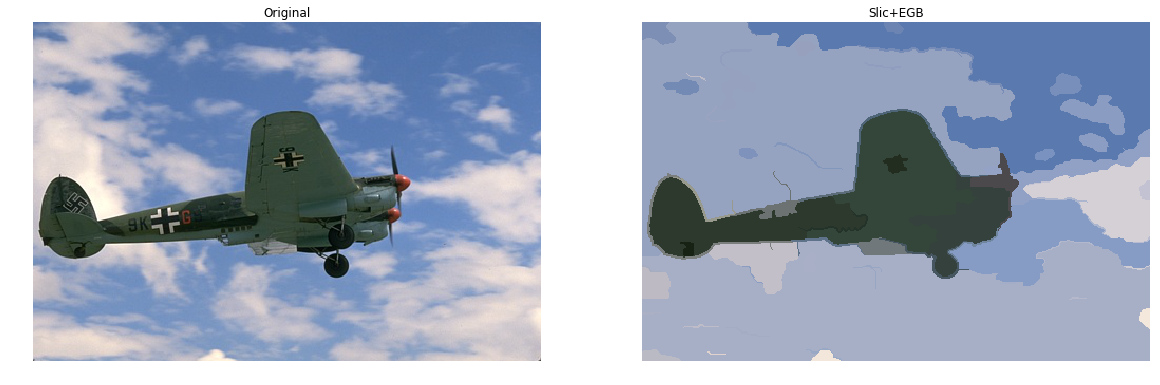

4


In [81]:
imagePath = 'images/'
imageFile ='3063.jpg'
image = img_as_float(io.imread((imagePath + imageFile)))

fs_image, _, cutz_images = sp.process_image(image
                                    , slic_segments = 896
                                    , felz_scale = 1024
                                    , felz_min_size = 20
                                    , ultrametric = True
                                    , save=False
                                    , filename = ''
                                    , paths=[]
                                    , ult_step = 1
                                    , ult_start_at = 60
                                    , ult_stop_at = 55)

fig, (ax2, ax3) = plt.subplots(1,2, figsize=(20, 20))
ax2.imshow(image)
ax2.set_title("Original")
ax2.set_axis_off()
ax3.imshow(fs_image)
ax3.set_title("Slic+EGB")
ax3.set_axis_off()
plt.show() 

print(len(cutz_images))

In [82]:
ground_file ='3063.mat'
groundtruth = pgt.get_groundTruth(imagePath + ground_file)

ground_image = np.zeros(image.shape,dtype=np.uint8)
for i in range(0,3):
    ground_image[:, :, i] = groundtruth[:, :, 0]

img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)
    
best_fmeasure = 0
for i in range(len(cutz_images)):
    precision, recall = ev.eval_bound(groundtruth, cutz_images[i], 0, True)
    fmeasure = 2 * ((precision * recall) / (precision + recall))
    
    print(fmeasure)
    if fmeasure > best_fmeasure:
        best_fmeasure = fmeasure
    
print('Best:', best_fmeasure)

0.279674610449
0.279674610449
0.282621416033
0.282621416033
Best: 0.282621416033


### Read Groundtruth

In [56]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

images = []
groundtruths = []

#load images
for filename in ground_filenames:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)
    
print(len(groundtruths), len(images))

100 100


### Generate boundaries and save results

In [83]:
ini = 0
fim = len(ground_filenames)

methods = ['hsegb']

index = 0

for method in methods:
    boundname = bound_prefix + method + extension

    borders = []
    last_shape = None
    img = None
    
    starttime = time.time()
    for groundtruth, image in zip(groundtruths[ini:fim], images[ini:fim]):
        if(image.shape != last_shape):
            _, _, cutz_images = sp.process_image(image
                                                , slic_segments = 896
                                                , felz_scale = 1024
                                                , felz_min_size = 20
                                                , ultrametric = True
                                                , save=False
                                                , filename = ''
                                                , paths=[]
                                                , ult_step = 2
                                                , ult_start_at = 58
                                                , ult_stop_at = 50)
        
        borders.append(cutz_images)
        
        index += 1
        if index % 10 == 0:
            print(index)

    endtime = time.time()
        
    np.savez(boundname, borders=borders)
    print(boundname)
    print((endtime - starttime), 'seconds')

10
20
30
40
50
60
70
80
90
100
save/bound_hsegb.npz
347.01523780822754 seconds


### Recover boundaries and evaluate results

In [84]:
ini = 0
fim = len(ground_filenames)

methods = ['hsegb']

for method in methods:
    boundname = bound_prefix + method + extension
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(boundname)
    boundaries = npload['borders']

    #start precision method
    precisions, recalls = [], []
    threshold = 0

    starttime = time.time()
    
    for groundtruth, cutz_images in zip(groundtruths[ini:fim], boundaries):
        cutz_precs, cutz_recs = [], []
        
        for cutz_image in cutz_images:
            precision, recall = ev.eval_bound(groundtruth, cutz_image, threshold, True)
            
            cutz_precs.append(precision)
            cutz_recs.append(recall)
            
        precisions.append(cutz_precs)
        recalls.append(cutz_recs)

    endtime = time.time()
    
    #save precision file
    np.savez(evalname, precisions=precisions, recalls=recalls)
    print(evalname)
    print((endtime - starttime), 'seconds')

save/precision_hsegb.npz
146.4265124797821 seconds


### Load evaluations and calculate f-measures

In [87]:
methods = ['hsegb']
fmeasures = []

for method in methods:
    evalname = eval_prefix + method + extension

    #load bound file
    npload = np.load(evalname)
    precisions = npload['precisions']
    recalls = npload['recalls']
    
    for i in range(0,4):
        cutz_precision, cutz_recall = [], []
        
        for precision, recall in zip(precisions, recalls):
            cutz_precision.append(precision[i])
            cutz_recall.append(recall[i])
    
        np_precisions = (np.array(cutz_precision))
        np_recalls = (np.array(cutz_recall))

        fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
        fmeasures.append(fmeasure)
        
        #print(fmeasures)
print(np.average(fmeasures, axis=1))

[ 0.24231289  0.24220216  0.24235018  0.24234473]
